<a href="https://colab.research.google.com/github/shashavali-d/Challenges/blob/master/6SenseWorkItem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Purchase Prediction using Tensorflow Estimator API**

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [0]:
#do not show warnings
import warnings 
warnings.filterwarnings("ignore")

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip /content/drive/My\ Drive/6takehome.zip 

Archive:  /content/drive/My Drive/6takehome.zip
   creating: takehome/
  inflating: takehome/readme.txt     
  inflating: takehome/test.tsv       
  inflating: takehome/training.tsv   


In [0]:
#Read the train/test dataset in to Pandas datframe and assuming dataset path as current working directory

train_columns = ['user_id', 'activity_date', 'activity_type']

dftrain = pd.read_csv('./takehome/training.tsv', names = train_columns, sep = '\t')

dftest = pd.read_csv('./takehome/test.tsv', names = train_columns, sep = '\t')

 **Remove unnecessary columns 'CustomerSupport' and reduce the imbalanced data 'EmailOpen'**

>

In [0]:
df_sample = dftrain.loc[dftrain['activity_type'] == 'EmailOpen']
df = dftrain.loc[dftrain['activity_type'] != 'EmailOpen']
df = df.loc[df['activity_type'] != 'CustomerSupport']
df_sampled = df_sample.sample(frac=0.10)
df_train = pd.concat([df_sampled, df]).reset_index(drop = True)

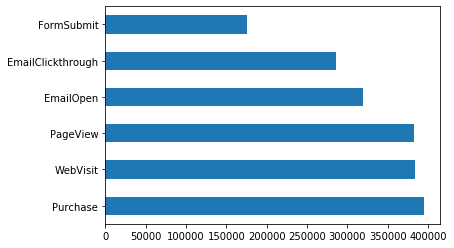

In [46]:
df_train['activity_type'].value_counts().plot(kind='barh')

In [0]:
activity_type_map = {
   'EmailOpen': 1,
   'EmailClickthrough': 2,
   'WebVisit': 3, 
   'PageView': 4, 
   'FormSubmit' : 5,
   'Purchase': 6  
}

In [0]:
df['activity_seq'] = df['activity_type'].apply(lambda x: activity_type_map[x])

In [49]:
#df_group = df.groupby(['user_id', 'activity_date', 'activity_type']).sum().reset_index()
#df = df.drop(['activity_date', 'activity_type'], axis = 1)
df.head(5)

,user_id,activity_date,activity_type,activity_seq
1,00002acbe042d69,2013-07-11,FormSubmit,5
30,0000ecf58c94668,2013-10-30,Purchase,6
31,0000ecf58c94668,2013-11-08,Purchase,6
32,0000ecf58c94668,2013-12-06,Purchase,6
33,0000ecf58c94668,2014-02-24,EmailClickthrough,2


In [50]:
grouped_df = df.groupby(['user_id'])
user_act_list = []
for i, j in grouped_df:
  temp_list = grouped_df.get_group(i)['activity_seq'].values
  temp_dict = {}
  temp_dict['user_id'] = i
  temp_dict['len'] = len(temp_list)
  temp_dict['activity_sequence'] = temp_list
  temp_dict['label'] = 1 if 6 in temp_list else 0
  user_act_list.append(temp_dict)

train_df = pd.DataFrame(user_act_list)
len(train_df)

191149

In [51]:
dftest['activity_seq'] = dftest['activity_type'].apply(lambda x: activity_type_map[x])
grouped_testdf = dftest.groupby(['user_id'])
testuser_act_list = []
for i, j in grouped_testdf:
  temp_list = grouped_testdf.get_group(i)['activity_seq'].values
  temp_dict = {}
  temp_dict['user_id'] = i
  temp_dict['len'] = len(temp_list)
  temp_dict['activity_sequence'] = temp_list
  testuser_act_list.append(temp_dict)

test_df = pd.DataFrame(testuser_act_list)
len(test_df)

132810

In [0]:
train_df.tail(4)

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191149 entries, 0 to 191148
Data columns (total 4 columns):
user_id              191149 non-null object
len                  191149 non-null int64
activity_sequence    191149 non-null object
label                191149 non-null int64
dtypes: int64(2), object(2)
memory usage: 5.8+ MB


In [52]:
train_df.drop(train_df[train_df['len'] > 300].index, inplace = True)
max_len = train_df.len.max()
#train_df['activity_sequence'] = train_df['activity_sequence'].apply(lambda x : sequence.pad_sequences(x, maxlen=max_len))
max_len

300

In [0]:
labels = train_df.pop('label')

In [54]:
X = train_df['activity_sequence']
X_TrainSeqs = sequence.pad_sequences(X, maxlen=max_len, padding='post')
X_TrainSeqs.shape

(190583, 300)

In [61]:
X_test = test_df['activity_sequence']
X_TestSeqs = sequence.pad_sequences(X_test, maxlen=max_len, padding='post')
X_TestSeqs.shape

(132810, 300)

In [55]:
model = Sequential([
    Flatten(input_shape=(190583, 300)),
    Dense(20, activation=tf.nn.relu),
    Dense(2, activation=tf.nn.sigmoid)
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 57174900)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1143498020
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 1,143,498,062
Trainable params: 1,143,498,062
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.fit(X_TrainSeqs, labels, batch_size=32, epochs=10)

ValueError: ignored

**RandomForest** model from sklearn

In [59]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rfmodel = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
rfmodel.fit(X_TrainSeqs, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
predicts = rfmodel.predict(X_TestSeqs)

In [77]:
print (len(predicts))
test_predicts = np.where(predicts == 1)
test_predicts

132810


(array([16221, 24368]),)

In [78]:
len(test_predicts)

1

**TensorFlow** model

In [0]:
# Divide the features in to numeric and categorical
NUMERICAL_COLUMNS = ['len', 'activity_sequence']

In [0]:
feature_columns = []
for header in NUMERICAL_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(header))

In [0]:
def train_input_fn(dataset, lab):
    return  tf.estimator.inputs.pandas_input_fn(dataset, queue_capacity = 1000,
                                               y = lab, batch_size = 64, shuffle = True, num_epochs = 3)

In [0]:
model = tf.estimator.DNNClassifier(feature_columns=feature_columns, 
                                       hidden_units=[10, 20, 40, 80], 
                                       model_dir = './',
                                       optimizer=lambda: tf.train.AdamOptimizer(
                                           learning_rate=tf.train.exponential_decay(
                                               learning_rate=0.1,
                                               global_step=tf.train.get_global_step(),
                                               decay_steps=10000,
                                               decay_rate=0.96)))
trained_model = model.train(input_fn=train_input_fn(train_df, labels), steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ffafef251d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X a

InternalError: ignored